<a href="https://colab.research.google.com/github/javier-jaime/Tool-Crib/blob/master/Operations%20Research/Gurobi_Opti_201_Optimize_Electricity_Purchases.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intermediate Modeling - Part 2: Back for More Sun
Just as we expanded on the first modeling example from Opti 101 for the first example of Opti 201, we'll do the same here. This example is motivated by [IEEE's Predict+Optimize Technical Challenge](https://ieee-dataport.org/competitions/ieee-cis-technical-challenge-predictoptimize-renewable-energy-scheduling) in 2021.

In this example we are trying to minimize the amount of electricity purchased from the grid to supply a building with electricity over a 6-day period while meeting predicted demand. The building is outfitted with solar panels and two batteries to store and provide energy when appropriate. Decisions made at each 30-minute interval are:
1. Buy electricity from the grid
2. Charge/discharge the one battery
3. Charge/discharge the other battery

The output of the optimization model is a charge/discharge schedule for the batteries as well as the time periods where electricity will be purchased. The demand is forecasted using [Prophet](https://facebook.github.io/prophet/). The notebook for this part of the problem can be found [here](https://github.com/javier-jaime/Tool-Crib/blob/master/Operations%20Research/Gurobi_Opti_101_Creating_Input_for_an_Optimization_Model.ipynb) If you want to have the first notebook handy, you can find it [here](https://github.com/javier-jaime/Tool-Crib/blob/master/Operations%20Research/Gurobi_Opti_101_Minimize_Electricity_Use.ipynb).

This model is a lot more complicated that the first from Opti 101, so we can copy the formulation and code in a concise way and highlight the parts relevant to the features discussed in the second modeling session video.

In subsequent sections we'll see how to adapt this model to incorporate
- Multi-objective models,
- Multi-scenario models, and
- Solutions pools

## Opti 101 Model

### Formulation

#### Sets and Input Parameters

Batteries: $b \in B = \{\texttt{Battery0, Battery1}\}$

Time periods: $t \in T = \{0,1,...,179\}$ for the first Monday through Saturday of October, 2020

$c_{b}$: capacity of battery $b \in B \quad\quad \texttt{capacity[b]}$

$p_{b}$: loss of energy (as a percentage) during transfer into battery $b\in B \quad\quad \texttt{p}\_\texttt{loss[b]}$

$q_{b}$: quantity of initial energy in battery $b \in B \quad\quad \texttt{initial[b]}$

$solar_{t}$: solar power generation of the panel for time period $t \in T \quad\quad \texttt{solar}\_\texttt{values[b]}$

$d_{t}$: total building and class energy demand for time period $t\in T \quad\quad \texttt{total}\_\texttt{deamnd[t]}$

#### Decision Variables
Let $f^{in}_{b,t}$ be the amount each battery, $b$, `charges` at time period,  $t$, $\forall b\in B, t\in T$. $\quad\quad \texttt{flow}\_\texttt{in[b,t]}$

Let $f^{out}_{b,t}$ be the amount each battery `discharges`, similarly. $\quad\quad \texttt{flow}\_\texttt{out[b,t]}$

The max amount that each battery can charge or discharge in a single period to be 20 kW.

$s_{b,t}$ is the current amount of energy in battery, $b$, at the end of time period, $t, \forall b\in B, t\in T$. $\quad\texttt{state[b,t]}$

$gen_{t}$ is the amount of available solar energy that is used in period $t$, $\forall t \in T$. $\quad\texttt{gen[t]}$

$grid_{t}$ : This variable indicates the amount of energy purchased from the grid at time period, $t$, $\forall t \in T$.  $\quad\texttt{grid[t]}$

We are not considering the ability to "sell back" electricity, so $grid_t \ge 0$.

#### Constraints
**Power balance:**
$$
\begin{align}
\sum_b(f^{out}_{b,t}-p_bf^{in}_{b,t}) + gen_t + grid_t = d_t \quad \forall t \in T
\end{align}
$$

**Battery state:**

First time period's charge/discharge decision.

\begin{equation}
s_{b,0} = q_b + p_bf^{in}_{b,0} - f^{out}_{b,0}
\end{equation}

For each time period after (i.e. $t\ge1$), the state of a battery is found by:

\begin{equation}
s_{b,t} = s_{b,t-1} + p_bf^{in}_{b,t} - f^{out}_{b,t}, t \ge 1
\end{equation}

**Solar availability:**
$$
\begin{equation}
f^{in}_{\texttt{Battery0},t} + f^{in}_{\texttt{Battery1},t} + gen_t \le solar_t, \quad \forall t \in T
\end{equation}
$$

**Charge/discharge:**
We cannot charge and discharge the same battery in the same time period.
Define $z_{b,t} \in \{0,1\}, \forall b \in B, t \in T$.
$$
\begin{align*}
f^{in}_{b,t} &\leq 20*z_{b,t} &\forall b \in B, t \in T \\
f^{out}_{b,t} &\leq 20*(1-z_{b,t}) &\forall b \in B, t \in T
\end{align*}
$$
Hmm, this set of constraints looks a little familiar, huh?

**Battery capacity:**
$$
\begin{align*}
s_{b,t} \le c_b, \quad \forall b \in B, t\in T
\end{align*}
$$

#### Objective Function
The objective is to minimize the total amount of energy purchased from the grid over all time periods.

\begin{equation}
{\rm min} \space \sum_{t} g_{t}
\end{equation}

### Gurobipy Code

#### Sets and Input parameters

In [8]:
# install/import packages
%pip install gurobipy
import pandas as pd
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

# read in solar forecast data
path = 'https://raw.githubusercontent.com/javier-jaime/Tool-Crib/master/Operations%20Research/Solar_Data/'
solar_values_read = pd.read_csv(path+'pred_solar_values.csv')
solar_values = round(solar_values_read.yhat,3)
solar_values.reset_index(drop = True, inplace = True)

# read in demaind data, where total demand is a fixed building demand and
# an estimated demand based on a proposed schedule for the building
schedule = pd.read_csv(path+'schedule_demand.csv')
avg_building = pd.read_csv(path+'building_demand.csv')
total_demand = schedule.sched_demand + avg_building.build_demand
print(f"Total Solar Generation: {solar_values.sum()} \nTotal Demand: {total_demand.sum()}")

# create data for batteries, including capity, efficency and initial charges
# also define time periods,
batteries = ["Battery0", "Battery1"]
capacity = {"Battery0": 60, "Battery1": 80} # in Kw
p_loss = {"Battery0": 0.95, "Battery1": 0.9} # proportion
initial = {"Battery0": 0, "Battery1": 0} # in kW
time_periods = range(len(solar_values_read))

Total Solar Generation: 4917.696 
Total Demand: 5250.6


#### Decison Variables

In [9]:
m = gp.Model() #this defines the model that we'll add to as we finish the formulation

flow_in = m.addVars(batteries, time_periods, name="flow_in")
flow_out = m.addVars(batteries, time_periods, name="flow_out")

grid = m.addVars(time_periods, name="grid")
state = m.addVars(batteries, time_periods, ub = [capacity[b] for b in batteries for t in time_periods], name="state")
gen = m.addVars(time_periods, name="gen")

zwitch = m.addVars(batteries, time_periods, vtype=GRB.BINARY, name="zwitch")

#### Constraints
Note than the **capacity constraint** has been taken care of by putting an `ub` on the `state` decision variable.

In [10]:
# Power balance
m.addConstrs((gp.quicksum(flow_out[b,t] - p_loss[b]*flow_in[b,t] for b in batteries) + gen[t] + grid[t] == total_demand[t]
                  for t in time_periods), name="power_balance");
# Battery state
m.addConstrs((state[b,0] == initial[b] + p_loss[b]*flow_in[b,0] - flow_out[b,0] for b in batteries), name="initial_state")
m.addConstrs((state[b,t] == state[b,t-1] + p_loss[b]*flow_in[b,t] - flow_out[b,t] for b in batteries for t in time_periods if t >= 1), name="subsequent_states");

#Solar availability
m.addConstrs((flow_in['Battery0',t] + flow_in['Battery1',t] + gen[t] <= solar_values[t] for t in time_periods), name = "solar_avail");

#Charge/discharge
m.addConstrs((flow_in[b,t] <= 20*zwitch[b,t] for b in batteries for t in time_periods), name = "to_charge")
m.addConstrs((flow_out[b,t] <= 20*(1-zwitch[b,t]) for b in batteries for t in time_periods), name = "or_not_to_charge");


#### Objective Function
The original objective is to minimize the amount of electricity purchased from the grid. There was also a section where we considered a different objective -- given expected electricity prices for each period, minimize the total cost. So we can compare the cost and amount of electricity purchased across scenarios, let's start to capture these values.

In [11]:
# read in estimated price of electricity for each time period
avg_price = pd.read_csv(path+'expected_price.csv')
price = avg_price.price

# define a linear expression for total energy purchased from the grid
total_grid = grid.sum()
# define a linear expression for total cost
total_cost = gp.quicksum(avg_price.price[t]*grid[t] for t in time_periods)

# set the objective to the original of min grid purchase
m.setObjective(total_grid, GRB.MINIMIZE)

### Solve the Model

In [12]:
m.optimize()

results = pd.DataFrame([[round(v,2) for v in [total_cost.getValue(),total_grid.getValue()]]],
                       columns = ['Cost','GridAmount']
                       )

results

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 1440 rows, 1800 columns and 4498 nonzeros
Model fingerprint: 0x7e94c9fe
Variable types: 1440 continuous, 360 integer (360 binary)
Coefficient statistics:
  Matrix range     [9e-01, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e-01, 9e+01]
Found heuristic solution: objective 5250.6000000
Presolve removed 84 rows and 265 columns
Presolve time: 0.01s
Presolved: 1356 rows, 1535 columns, 4109 nonzeros
Found heuristic solution: objective 4991.1510000
Variable types: 1199 continuous, 336 integer (336 binary)

Root relaxation: objective 1.294073e+03, 617 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Inc

,Cost,GridAmount
0,830.22,1294.07


The original objective is to minimize the amount of electricity purchased from the grid. There was also a section where we considered a different objective -- given expected electricity prices for each period, minimize the total cost. We'll read in the data and quickly update the objective and resolve.

In [13]:
m.setObjective(total_cost, GRB.MINIMIZE)
m.optimize()

results = pd.concat([results,
                     pd.DataFrame([[round(v,2) for v in [total_cost.getValue(),total_grid.getValue()]]], columns = ['Cost','GridAmount'])
                     ],
                    ignore_index=True
                    )

results
#create a copy for later
mp = m.copy()

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 1440 rows, 1800 columns and 4498 nonzeros
Model fingerprint: 0x61947127
Variable types: 1440 continuous, 360 integer (360 binary)
Coefficient statistics:
  Matrix range     [9e-01, 2e+01]
  Objective range  [6e-02, 2e+00]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e-01, 9e+01]

MIP start from previous solve produced solution with objective 615.995 (0.03s)
MIP start from previous solve produced solution with objective 615.995 (0.03s)
Loaded MIP start from previous solve with objective 615.995

Presolve removed 84 rows and 265 columns
Presolve time: 0.01s
Presolved: 1356 rows, 1535 columns, 4109 nonzeros
Variable types: 1199 continuous, 336 integer (336 binary)

Root relaxation: objective 6.074759e+02, 732 iterations, 0.01 seconds (0.02 wor

## Let's Find Some Hidden Gems

### Handling Multiple Objectives

The above results show two different scenarios, one that purely considers grid purchases, and the other purely prioritizes cost. Let's see how to use Gurobi's [multi-objective](https://www.gurobi.com/documentation/current/refman/working_with_multiple_obje.html) functionality to combine the two objectives by first implementing a `weigthed` setup.

#### Weighted Objectives
In using a weighted objective, we need to obviously decide the `weights`. This can be a little tricky given units and scale.

In [14]:
m.setObjectiveN(total_cost, index=0, weight = 1, name="cost")
m.setObjectiveN(total_grid, index=1, weight = 10, name= "grid")

Now we can run the optimization with our weighted objective.

In [15]:
m.ModelSense = GRB.MINIMIZE
m.optimize()

results = pd.concat([results,
                     pd.DataFrame([[round(v,2) for v in [total_cost.getValue(),total_grid.getValue()]]], columns = ['Cost','GridAmount'])
                    ],
                    ignore_index=True
                    )

results

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 1440 rows, 1800 columns and 4498 nonzeros
Model fingerprint: 0xebec1a03
Variable types: 1440 continuous, 360 integer (360 binary)
Coefficient statistics:
  Matrix range     [9e-01, 2e+01]
  Objective range  [6e-02, 2e+00]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e-01, 9e+01]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives (1 combined) ...
---------------------------------------------------------------------------
---------------------------------------------------------------------------

Multi-objectives: optimize objective 1 (weighted) ...
---------------------------------------------------------------------------

Optimize a model with 1440 rows, 1

,Cost,GridAmount
0,830.22,1294.07
1,607.48,1331.24
2,622.16,1294.63


Using this multi-objective approach, we have been able to significantly reduce the cost from the first solution* while adding on a very small amount of grid purchase.

*Note that since we didn't specify anything in the first model that pertained to price there may be a solution that uses the same amout of purchased energy at a different cost.


#### Hierarchical Objectives
This kind of multi-objective approach gives priority to a given objective in a given order, and for subsequent objectives, constraints are added to make sure the expressions of prior objectives to not degrade beyond given values.

In the `hierarchical` approach the two main arguments are `abstol` and `reltol`. The former allows the first objective to degrade by a *raw* amount, while the latter is a *percentage*.

For example, we can set first optimize for minimal total cost, and then allow that objective value to *degrade* by $50 or by a factor of 0.1 (i.e. increase by 10%) when we then minimize for the lowest amount of electricity purchased.

An important concept in energy storage in maintaining battery health. One way this may be handled is to limit a battery's [depth of discharge](https://en.wikipedia.org/wiki/Depth_of_discharge), which can be expressed as the percentage of a battery's capacity that has been discharged. The way we decide to do this is by limiting the number of time periods our batteries are discharged below a certain depth.

To do this we'll need binary variables to indicate when this occurs.

Let $v_{b,t} = 1$ when battery $b$ is below a depth of discharge α (say 0.3) and 0 otherwise. We want to model

"If the battery gets below 30% it's capacity, then indicate depth of discharge violation."

Let's replace some what comes after "If" and "then" with decision variables and (in)equalities. As a reminder $s_{b,t}$ is the current charge in the battery and $c_b$ is its capacity.

$$
If \space s_{b,t} < 0.3 \times c_b, \space then \space v_{b,t} = 1
$$

We can easily model this by taking the contrapositive of the conditional statement above and using indicator constraints.

$$
If \space v_{b,t} = 0, \space then \space s_{b,t} \ge 0.3 \times c_b,
$$

````
To keep the problem within the 2,000 variable limit that comes with the `pip` install license,
this will only be implemented for `Battery0`.
````

In [16]:
# Reminder that s_{b,t} is defined by state[b,t] in the code
v = m.addVars(time_periods, vtype=GRB.BINARY, name = 'v')

# define a linear expression for total depth count
total_depth_count = v.sum()
# remember to implement this constraint for battery 0 only
m.addConstrs((((v[t] == 0) >> (state['Battery0',t] >= 0.3*capacity['Battery0'])) for b in batteries for t in time_periods), name = "discharge_depth")
m.update()

Now we'll dive into a three-piece objective with cost as our highest priority, depth of discharge count second, and grid purchase third.

In [17]:
#the higher priority number is used first as an objective
m.setObjectiveN(total_cost, index=0, priority=2, reltol = 0.05, name="cost")
m.setObjectiveN(total_depth_count, index=1,  priority=1, reltol = 0.2, name= "depth")
m.setObjectiveN(total_grid, index=2, priority=0, name= "grid")

In [18]:
m.optimize()

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 1440 rows, 1980 columns and 4498 nonzeros
Model fingerprint: 0x5cfcd2be
Model has 360 general constraints
Variable types: 1440 continuous, 540 integer (540 binary)
Coefficient statistics:
  Matrix range     [9e-01, 2e+01]
  Objective range  [6e-02, 2e+00]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e-01, 9e+01]
  GenCon rhs range [2e+01, 2e+01]
  GenCon coe range [1e+00, 1e+00]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 3 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve added 1004 rows a

We defined linear expressions for each part of the objective so we can use `getValue` to get their respective results. You can also query objectives as shown here.

In [19]:
for o in range(m.NumObj):
  # set which objective we will query
  m.params.ObjNumber = o
  # query the o-th objective value
  print(' ',round(m.ObjNVal,2), end='')

  637.91  14.0  1322.1

Play around with the priorities and tolerances to see how those change the overall solution.

### Handling Multiple Scenarios
In this section we will start with out **base model** with the objective being to minimize the total electricity purchase cost. To make is easier to edit constraints we can store.

In [20]:
mm = gp.Model('mulit_scen') #this defines the model that we'll add to as we finish the formulation
flow_in = mm.addVars(batteries, time_periods, name="flow_in")
flow_out = mm.addVars(batteries, time_periods, name="flow_out")
grid = mm.addVars(time_periods, name="grid")
state = mm.addVars(batteries, time_periods, ub = [capacity[b] for b in batteries for t in time_periods], name="state")
gen = mm.addVars(time_periods, name="gen")
zwitch = mm.addVars(batteries, time_periods, vtype=GRB.BINARY, name="zwitch")

# define a linear expression for total energy purchased from the grid
total_grid = grid.sum()
# define a linear expression for total cost
total_cost = gp.quicksum(avg_price.price[t]*grid[t] for t in time_periods)

power_balance = mm.addConstrs((gp.quicksum(flow_out[b,t] - p_loss[b]*flow_in[b,t] for b in batteries) + gen[t] + grid[t] == total_demand[t]
                  for t in time_periods), name="power_balance")
initial_state = mm.addConstrs((state[b,0] == initial[b] + p_loss[b]*flow_in[b,0] - flow_out[b,0] for b in batteries), name="initial_state")
subsequent_states = mm.addConstrs((state[b,t] == state[b,t-1] + p_loss[b]*flow_in[b,t] - flow_out[b,t] for b in batteries for t in time_periods if t >= 1), name="subsequent_states")
solar_avail = mm.addConstrs((flow_in['Battery0',t] + flow_in['Battery1',t] + gen[t] <= solar_values[t] for t in time_periods), name = "solar_avail")
to_charge = mm.addConstrs((flow_in[b,t] <= 20*zwitch[b,t] for b in batteries for t in time_periods), name = "to_charge")
or_not_to_charge = mm.addConstrs((flow_out[b,t] <= 20*(1-zwitch[b,t]) for b in batteries for t in time_periods), name = "or_not_to_charge")

mm.setObjective(total_cost, GRB.MINIMIZE)
mm.update()

#### Compare Four Scenarios
Here we'll outline four different scenarios that, outside of the base scenario, change the objective coefficients, variable bounds, and constraint RHS, respectively.
0. Base Scenario as above
> We'll set the number of scenarios and let the first be the base case.



In [21]:
mm.NumScenarios=4
mm.Params.ScenarioNumber = 0
mm.ScenNName = 'Base model'

1. (Mostly) higher costs
>Another column was added to the price dataframe where the original price was altered so high prices have become even higher and low prices have become even lower. The exact multiplier was random so the prices may seem to jump up and down a little more.

In [22]:
price2 = avg_price.price2
# change obj
mm.Params.ScenarioNumber = 1
mm.ScenNName = 'Increased price'
for t in time_periods:
  grid[t].ScenNObj = price2[t]

2. Lower Battery Capacity
> Reduced battery capacities from 60 $→$ 48 and 80 $→$ 64.


In [23]:
capacity2 = {'Battery0': 48, 'Battery1': 64}
# change variable bound
mm.Params.ScenarioNumber = 2
mm.ScenNName = 'Low Battery'
for b in batteries:
  for t in time_periods:
    state[b,t].ScenNUB = capacity2[b]

3. Higher Solar
>The solar prediction data frame has many other columns as standard output for a Prophet model (this was used to predict the solar availability). We'll take a convex combination of a lower estimate, point estimate, and upper estimate to create a new value for solar availability. The weights chosen will increase the forecast.

In [24]:
solar_values2 = round(0.1*solar_values_read.yhat_lower +
                      0.6*solar_values_read.yhat +
                      0.3*solar_values_read.yhat_upper,3)
# just in case any forecasted value is negative, set it to 0
solar_values2[solar_values2 < 0] = 0

# change constraint RHS
mm.Params.ScenarioNumber = 3
mm.ScenNName = 'High Solar'
for t in time_periods:
    solar_avail[t].ScenNRhs = solar_values2[t]

#### Querying Scenarios
We can now write an `.lp` file and optimize the scenarios. What do you see in the log that shows how Gurobi tries to solve these scenarios efficiently?

In [25]:
mm.write('ms.lp')
mm.optimize()

#print obj value from each scenario
for s in range(mm.NumScenarios):
    # Set the scenario number to query the information for this scenario
    mm.Params.ScenarioNumber = s
    print('\nTotal cost for '+mm.ScenNName+' is '+'$'+str(round(mm.ScenNObjVal,2)))

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 1440 rows, 1800 columns and 4498 nonzeros
Model fingerprint: 0x3cc9997f
Variable types: 1440 continuous, 360 integer (360 binary)
Coefficient statistics:
  Matrix range     [9e-01, 2e+01]
  Objective range  [6e-02, 3e+00]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e-01, 9e+01]

Solving a multi-scenario model with 4 scenarios...

Found heuristic solution: objective 2722.4370000
Presolve removed 103 rows and 89 columns
Presolve time: 0.02s
Presolved: 1872 rows, 1889 columns, 5668 nonzeros
Presolved model has 4 scenario(s)
Found heuristic solution: objective 2713.0821600
Variable types: 1549 continuous, 340 integer (340 binary)
Found heuristic solution: objective 870.6734960

Root relaxation: objective 4.484327e+02, 1312 iterations, 0.02 sec

### Solution Pools
Dive in, the water's fine!

A solution pool allows you to find multiple solutions that satisfy some criteria base off of search parameters set.

In [26]:
# Limit how many solutions to collect
mp.setParam(GRB.Param.PoolSolutions, 250)
# Limit the search space by setting a gap for the worst possible solution that will be accepted
mp.setParam(GRB.Param.PoolGap, 0.05)
# do a systematic search for the k-best solutions
mp.setParam(GRB.Param.PoolSearchMode, 2)

mp.optimize()

Set parameter PoolSolutions to value 250
Set parameter PoolGap to value 0.05
Set parameter PoolSearchMode to value 2
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Ubuntu 22.04.3 LTS")

CPU model: AMD EPYC 7B12, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 1440 rows, 1800 columns and 4498 nonzeros
Model fingerprint: 0x61947127
Variable types: 1440 continuous, 360 integer (360 binary)
Coefficient statistics:
  Matrix range     [9e-01, 2e+01]
  Objective range  [6e-02, 2e+00]
  Bounds range     [1e+00, 8e+01]
  RHS range        [1e-01, 9e+01]
Found heuristic solution: objective 2722.4370000
Presolve removed 59 rows and 59 columns
Presolve time: 0.01s
Presolved: 1381 rows, 1741 columns, 4306 nonzeros
Variable types: 1381 continuous, 360 integer (360 binary)

Root relaxation: objective 6.074759e+02, 784 iterations, 0.03 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objec

Now we can query all 250 solutions for variables of interest and look for anything interesting.

In [27]:
flow_250 = pd.DataFrame()
for i in range(250):
  mp.setParam(GRB.Param.SolutionNumber, i)
  tmp = pd.DataFrame([[b, t, flow_in[b,t].Xn, flow_out[b,t].Xn, i] for b in batteries for t in time_periods], columns=['battery', 'time_period', 'out','in','Scen'])
  flow_250 = pd.concat([flow_250, tmp], axis = 0, ignore_index=True)
flow_250

,battery,time_period,out,in,Scen
0,Battery0,0,0.000,0.000000,0
1,Battery0,1,3.242,0.000000,0
2,Battery0,2,0.000,0.000000,0
3,Battery0,3,0.000,0.000000,0
4,Battery0,4,0.000,3.079900,0
...,...,...,...,...,...
89995,Battery1,175,0.000,0.000000,249
89996,Battery1,176,0.000,4.401436,249
89997,Battery1,177,0.000,0.000000,249
89998,Battery1,178,0.000,0.000000,249


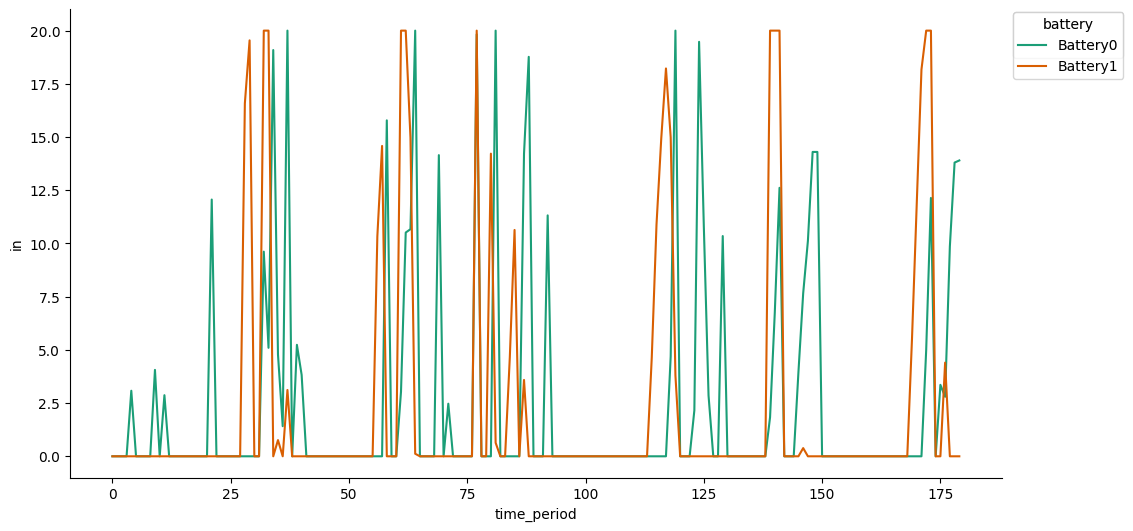

In [29]:
# @title time_period vs in

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['time_period']
  ys = series['in']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = flow_250.sort_values('time_period', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('battery')):
  _plot_series(series, series_name, i)
  fig.legend(title='battery', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('time_period')
_ = plt.ylabel('in')

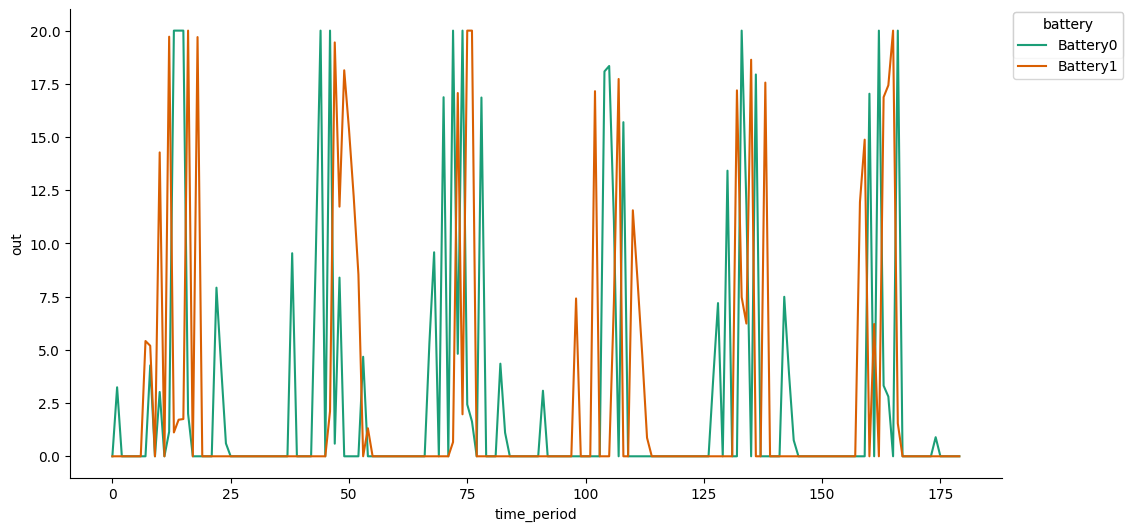

In [28]:
# @title time_period vs out

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['time_period']
  ys = series['out']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = flow_250.sort_values('time_period', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('battery')):
  _plot_series(series, series_name, i)
  fig.legend(title='battery', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('time_period')
_ = plt.ylabel('out')